# Sentiment Analysis

### Packages

In [3]:
#pip install TextBlob
#pip install nltk

In [5]:
import pandas as pd
import numpy as np
import re 
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


### Step 1: Data Collection / Inspection

In [8]:
tweet_data = pd.read_csv('Bitcoin_tweets.csv')

In [9]:
tweet_data.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False


In [10]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48583 entries, 0 to 48582
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         48581 non-null  object
 1   user_location     28272 non-null  object
 2   user_description  45263 non-null  object
 3   user_created      48583 non-null  object
 4   user_followers    48583 non-null  int64 
 5   user_friends      48583 non-null  int64 
 6   user_favourites   48583 non-null  int64 
 7   user_verified     48583 non-null  bool  
 8   date              48583 non-null  object
 9   text              48583 non-null  object
 10  hashtags          38416 non-null  object
 11  source            47685 non-null  object
 12  is_retweet        48583 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 4.2+ MB


In [12]:
tweet_data.describe()

,user_followers,user_friends,user_favourites
count,4.858300e+04,48583.000000,48583.000000
mean,5.703531e+03,1155.908836,6068.639051
std,5.368779e+04,5610.680001,19140.017316
min,0.000000e+00,0.000000,0.000000
25%,7.400000e+01,45.000000,57.000000
50%,3.930000e+02,221.000000,568.000000
75%,2.151000e+03,822.000000,3855.000000
max,3.977233e+06,701484.000000,488627.000000


In [13]:
tweet_data.shape

(48583, 13)

### Data Exploration & Cleaning

Lets get some visuals of the different numeric variables

In [22]:
#user_followers, user_friends, user_favourites 

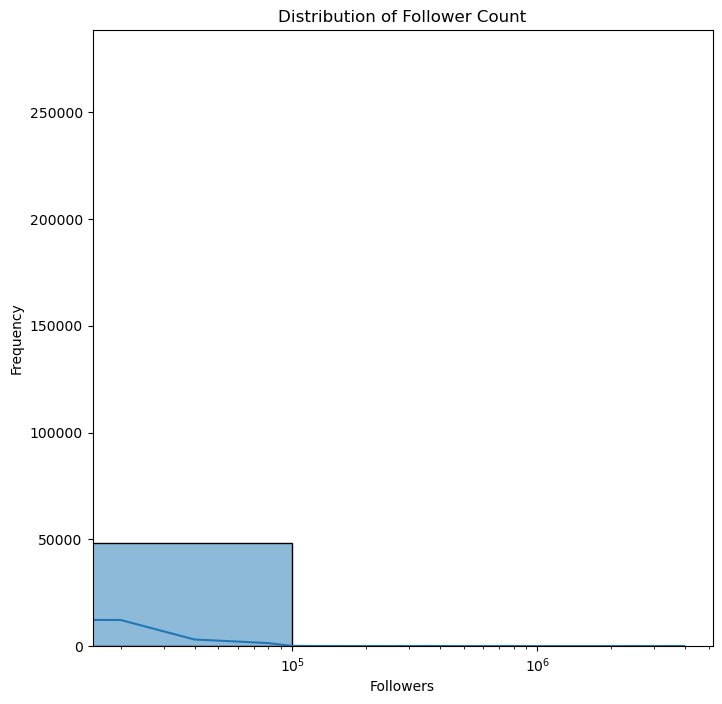

In [24]:
#use_followers distribution
plt.figure(figsize=(8,8))
sns.histplot(tweet_data['user_followers'], bins = 40, kde = True)

#x-axis scale
plt.xscale('log')

plt.title('Distribution of Follower Count')
plt.xlabel('Followers')
plt.ylabel('Frequency')
plt.show()

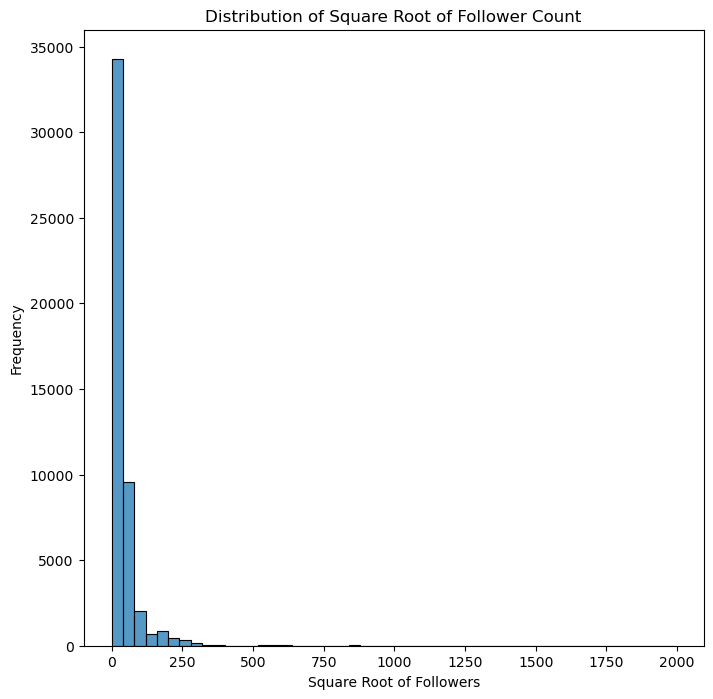

In [26]:
#transformation
tweet_data['sqrt_followers'] = np.sqrt(tweet_data['user_followers'])

#new plot
plt.figure(figsize=(8, 8))
sns.histplot(tweet_data['sqrt_followers'], bins=50)
plt.title('Distribution of Square Root of Follower Count')
plt.xlabel('Square Root of Followers')
plt.ylabel('Frequency')
plt.show()

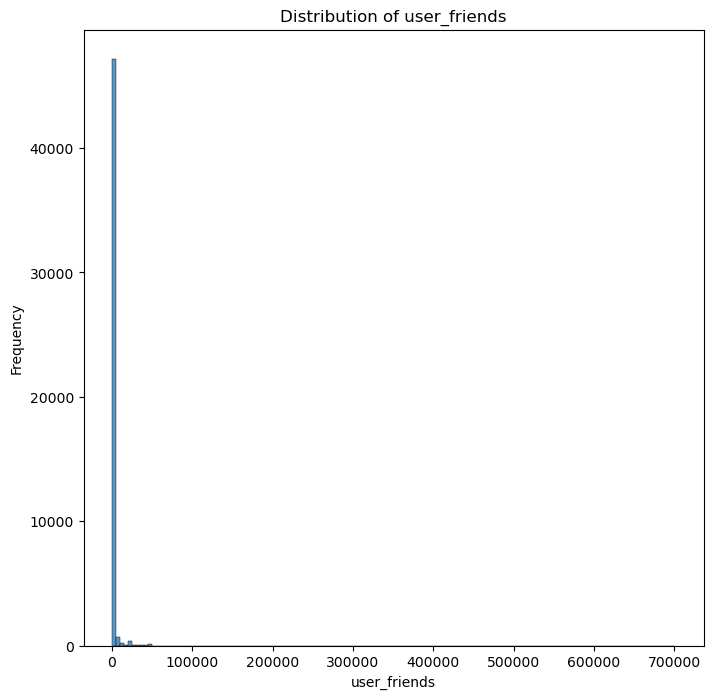

In [28]:
#User Friends plot
plt.figure(figsize=(8, 8))
sns.histplot(tweet_data['user_friends'], bins=140)
plt.title('Distribution of user_friends')
plt.xlabel('user_friends')
plt.ylabel('Frequency')
plt.show()

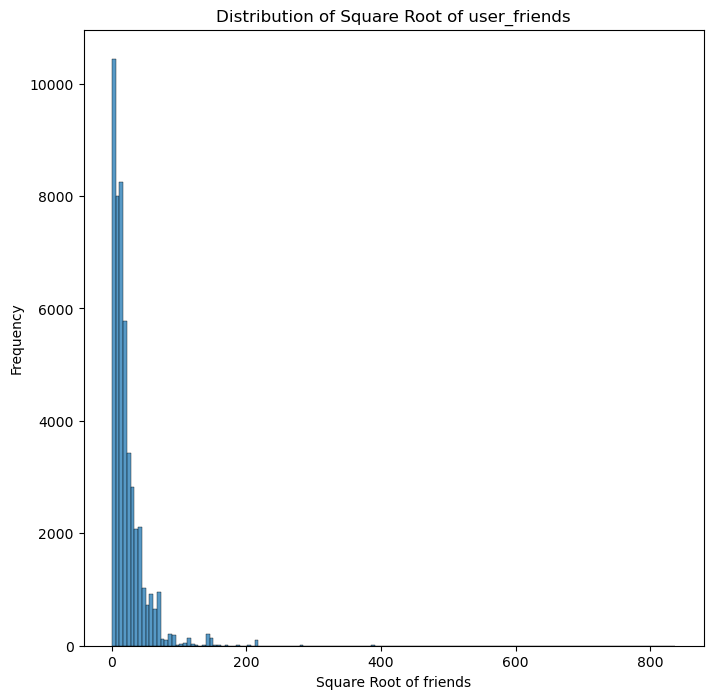

In [30]:
#transformation
tweet_data['sqrt_friends'] = np.sqrt(tweet_data['user_friends'])

#new plot
plt.figure(figsize=(8, 8))
sns.histplot(tweet_data['sqrt_friends'], bins=150)
plt.title('Distribution of Square Root of user_friends')
plt.xlabel('Square Root of friends')
plt.ylabel('Frequency')
plt.show()

Check for duplicates:

In [33]:
duplicates = tweet_data.duplicated()
print('Number of Duplicate rows: ', duplicates.sum())

Number of Duplicate rows:  0


Check missing values:

In [36]:
tweet_data.shape

(48583, 15)

In [38]:
missing_values = tweet_data.isnull().sum()
print(missing_values)

user_name               2
user_location       20311
user_description     3320
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
hashtags            10167
source                898
is_retweet              0
sqrt_followers          0
sqrt_friends            0
dtype: int64


lets create a dataframe of just the tweet text 

In [41]:
tweet_text = tweet_data['text']

In [43]:
tweet_text.head(3)

0    Blue Ridge Bank shares halted by NYSE after #b...
1    😎 Today, that's this #Thursday, we will do a "...
2    Guys evening, I have read this article about B...
Name: text, dtype: object

In [45]:
type(tweet_text)

pandas.core.series.Series

#### Lets create a function to process the tweet text

In [48]:
# NLTK Resrouces 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /Users/udemy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/udemy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/udemy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [50]:


def preprocess_text(text):
    'remove certain elements from the text & performs some transformations'

    #removes links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    #Removes mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    #remove punction and special characters
    text = re.sub(r'[^\w\s]', '', text)

    #Tokenize:
    tokens = word_tokenize(text)

    #remove stopewords and lemmatize

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [52]:
tweet_data['clean_text'] = tweet_data['text'].apply(preprocess_text)

In [53]:
tweet_data.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sqrt_followers,sqrt_friends,clean_text
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,92.379651,87.206651,Blue Ridge Bank share halted NYSE ATM announce...
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,82.273933,39.140772,Today thats Take 2 friend expe
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,11.313708,18.220867,Guys evening I read article BTC would like share


# Sentiment analysis

### TextBlob

- TextBlob is a Python library that provides easy-to-use tools for common natural language processing (NLP) tasks such as sentiment analysis  

- A built-in sentiment analysis function evaluates text using a predefined model, returning two metrics: polarity (ranging from -1 for negative to +1 for positive sentiment) and subjectivity

In [60]:
from textblob import TextBlob

- Function below calculates the sentiment polarity of a given text using the TextBlob library, where the input (text) in the function is a string in this case the tweets we will be analyzing.
- analysis = a TextBlob object created from the input text
- sentiment.polarity attribute is used to extract the sentiment polarity score.
- Output Returns polarity score (negative means negative sentiment and so on.....)

In [63]:
#Function to calculate sentiment:

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity # Returns a value between -1 (negative) and 1 (positive)


In [65]:
tweet_data['sentiment'] = tweet_data['clean_text'].apply(get_sentiment)

In [66]:
tweet_data.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sqrt_followers,sqrt_friends,clean_text,sentiment
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,92.379651,87.206651,Blue Ridge Bank share halted NYSE ATM announce...,0.0
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,82.273933,39.140772,Today thats Take 2 friend expe,0.0
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,11.313708,18.220867,Guys evening I read article BTC would like share,0.0


### Visualize TextBlob

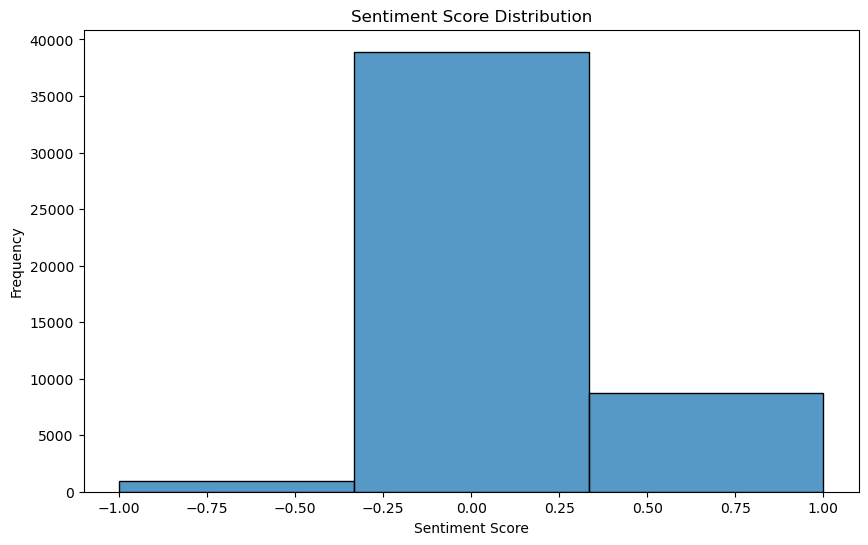

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(tweet_data['sentiment'], bins=3)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

### Vader:

- VADER: Valence Aware Dictionary and Sentiment Reasoner
- Specialized for social media and short text such as tweets
- Sentiment Scores: Positive, Negative Neutral Compound


In [71]:
#First install it
!pip install vaderSentiment


In [72]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


- Function: Calculates the compound sentiment score of a given text using the VADER sentiment analysis tool
- input is the text from the tweet
- similar to textblob calculates a score and returns it

In [77]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']  # Returns a value between -1 (negative) and 1 (positive)


In [81]:
tweet_data['vader_sentiment'] = tweet_data['clean_text'].apply(vader_sentiment)


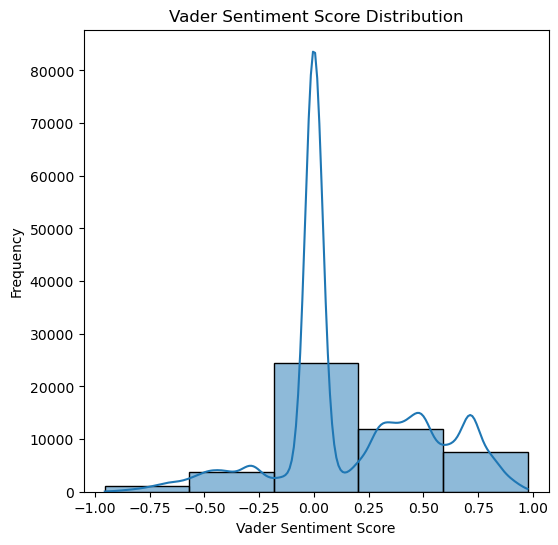

In [83]:
plt.figure(figsize=(6, 6))
sns.histplot(tweet_data['vader_sentiment'], bins=5, kde=True)
plt.title('Vader Sentiment Score Distribution')
plt.xlabel('Vader Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [85]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48583 entries, 0 to 48582
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_name         48581 non-null  object 
 1   user_location     28272 non-null  object 
 2   user_description  45263 non-null  object 
 3   user_created      48583 non-null  object 
 4   user_followers    48583 non-null  int64  
 5   user_friends      48583 non-null  int64  
 6   user_favourites   48583 non-null  int64  
 7   user_verified     48583 non-null  bool   
 8   date              48583 non-null  object 
 9   text              48583 non-null  object 
 10  hashtags          38416 non-null  object 
 11  source            47685 non-null  object 
 12  is_retweet        48583 non-null  bool   
 13  sqrt_followers    48583 non-null  float64
 14  sqrt_friends      48583 non-null  float64
 15  clean_text        48583 non-null  object 
 16  sentiment         48583 non-null  float6

#### Time Series:

In [90]:
tweet_data2 = tweet_data
tweet_data2['date'] = pd.to_datetime(tweet_data['date'])
tweet_data2.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,sqrt_followers,sqrt_friends,clean_text,sentiment,vader_sentiment
0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534,7605,4838,False,2021-02-10 23:59:04,Blue Ridge Bank shares halted by NYSE after #b...,['bitcoin'],Twitter Web App,False,92.379651,87.206651,Blue Ridge Bank share halted NYSE ATM announce...,0.0,0.2960
1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769,1532,25483,False,2021-02-10 23:58:48,"😎 Today, that's this #Thursday, we will do a ""...","['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,82.273933,39.140772,Today thats Take 2 friend expe,0.0,0.4939
2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128,332,924,False,2021-02-10 23:54:48,"Guys evening, I have read this article about B...",NaN,Twitter Web App,False,11.313708,18.220867,Guys evening I read article BTC would like share,0.0,0.5719


In [92]:
# Set the date column as the index
tweet_data2.set_index('date', inplace=True)

- Code analyzes the average sentiment of tweets over time, and aggregating sentiment scores on a daily basis to visualize trends.

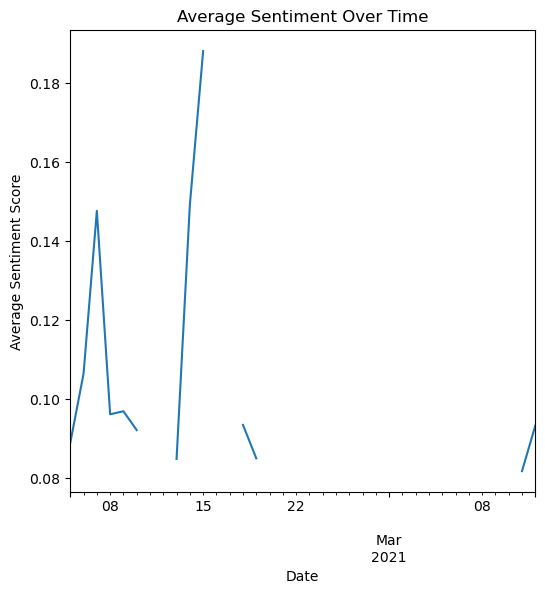

In [95]:
# "resample" to daily frequency and calculate mean sentiment
daily_sentiment = tweet_data2['sentiment'].resample('D').mean()


plt.figure(figsize=(6, 6))
daily_sentiment.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.show()


Do it again limit issues:
- date range
- Fill missing values with NaN
- fill missing values with forward-fill simple solution but works for this purpose

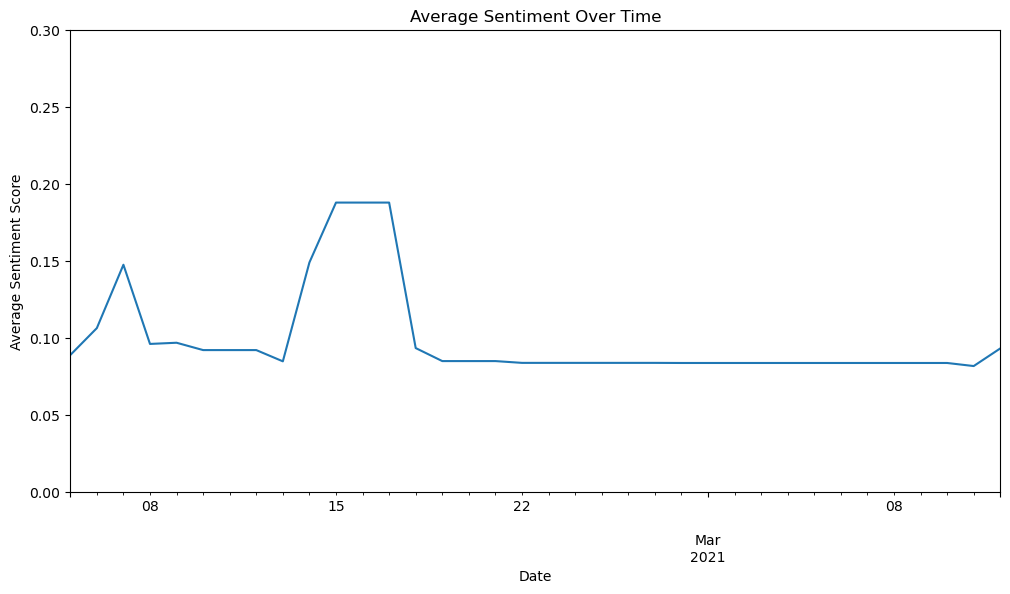

In [98]:
# Resample again
daily_sentiment = tweet_data2['sentiment'].resample('D').mean()

# Create a complete date range from the minimum to maximum date in the data
all_dates = pd.date_range(start=daily_sentiment.index.min(), end=daily_sentiment.index.max(), freq='D')

# Reindex the data to include all dates, this will fill missing values with NaN
daily_sentiment = daily_sentiment.reindex(all_dates)

#fill missing values with forward fill
# which fills with the last available non NaN value. 
daily_sentiment = daily_sentiment.ffill()  

# Plot the results
plt.figure(figsize=(12, 6))
plt.ylim(0, 0.3)
daily_sentiment.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.show()